In [12]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from networks import SimpleConv, AlexLike

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from trainer import Trainer

from einops import rearrange, reduce, repeat
from utils.timer import Timer

# %matplotlib inline

In [13]:
device = 'cuda'

print(os.getcwd())
path_data_base = '../data/'
path_images = os.path.join(path_data_base, 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')
path_img_train = os.path.join(path_images, 'train')
path_img_val = os.path.join(path_images, 'val')
path_img_test = os.path.join(path_images, 'test')

/home/bozidar/repos/pneumonia-xray/code


In [14]:
meta = pd.read_csv(os.path.join(path_data_base, 'Chest_xray_Corona_Metadata.csv'))
meta.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [15]:
train = meta[meta['Dataset_type'] == 'TRAIN'].copy().reset_index(drop=True)
test = meta[meta['Dataset_type'] == 'TEST'].copy().reset_index(drop=True)
n_train = len(train)
n_test = len(test)

train_name = train['X_ray_image_name']
train_label = train['Label']
test_name = test['X_ray_image_name']
test_label = test['Label']

print(f'{n_train=} {n_test=}')

n_train=5286 n_test=624


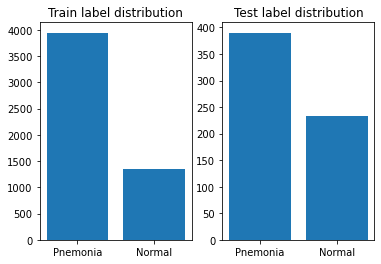

In [16]:
train_counts = train_label.value_counts()
test_counts = test_label.value_counts()

fig, ax = plt.subplots(1, 2)
ax[0].bar(train_counts.keys(), train_counts.values)
ax[1].bar(test_counts.keys(), test_counts.values)
ax[0].set_title('Train label distribution')
ax[1].set_title('Test label distribution')
fig.show()

In [17]:
# generate folder structure to use torchvision imageloader
def generate_data_folders(base_path, typ, img_paths, labels, split=None):
    # split - percentage of validation data
    l_unique = labels.unique()
    for l in l_unique:
        try:
            os.makedirs(os.path.join(base_path, typ, l))
            if split is not None:
                os.makedirs(os.path.join(base_path, 'val', l))
        except FileExistsError:
            # directory already exists
            pass

    for i in range(len(img_paths)):
        if (split is not None) and (np.random.rand() <= split):
            wr_path = os.path.join(base_path, 'val')
        else:
            wr_path = os.path.join(base_path, typ)

        shutil.move(os.path.join(base_path, typ, img_paths[i]), os.path.join(wr_path, labels[i], img_paths[i]))

# run the first time
# generate_data_folders(path_images, 'train', train_name, train_label, split=0.1)
# generate_data_folders(path_images, 'test', test_name, test_label)

In [18]:
img_h, img_w = 224, 224

inspect_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                   torchvision.transforms.ToTensor()])
inspect_data = torchvision.datasets.ImageFolder(path_img_train, transform=inspect_transform)
inspect_loader = DataLoader(inspect_data, batch_size=1, shuffle=True)

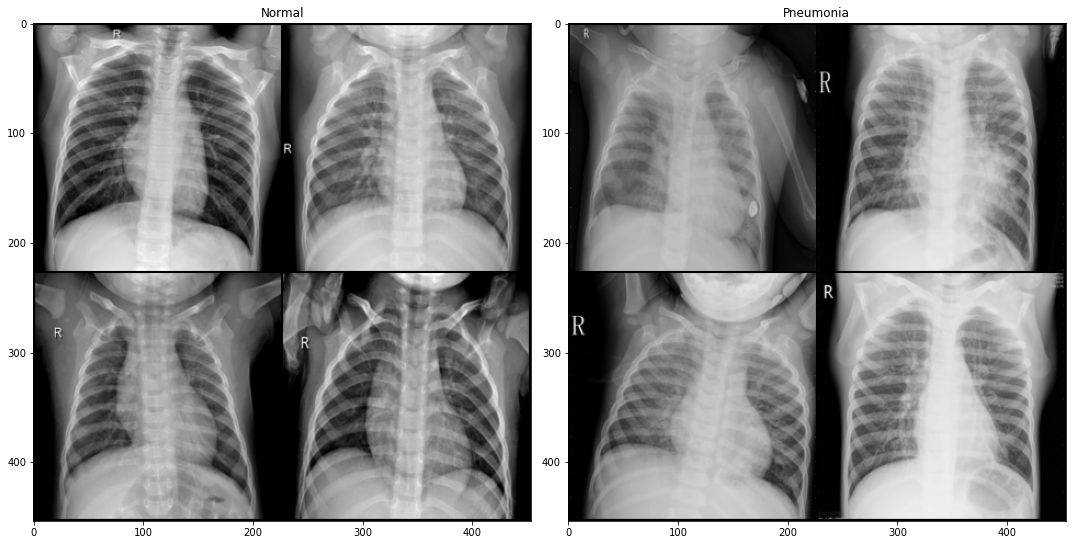

In [19]:
num = 4 # set even
cnt = [0, 0]
norm, pneum = [], [] 

for img, lbl in inspect_loader:
    if lbl == 1 and cnt[lbl] < num:
        pneum.append(img)
        cnt[lbl] += 1
    elif lbl == 0 and cnt[lbl] < num:
        norm.append(img)
        cnt[lbl] += 1
    elif cnt[0]+cnt[1] == 2*num:
        break
    
norm = torch.cat(norm, axis=0)
pneum = torch.cat(pneum, axis=0)
grid_norm = torchvision.utils.make_grid(norm, nrow=2)
grid_pneum = torchvision.utils.make_grid(pneum, nrow=2)

fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(rearrange(grid_norm, 'c h w -> h w c'))
ax[0].set_title('Normal')
ax[1].imshow(rearrange(grid_pneum, 'c h w -> h w c'))
ax[1].set_title('Pneumonia')
fig.show()
fig.tight_layout()

In [20]:
# only once to calculate values for normalization
# imgs = []
# inspect_loader = DataLoader(inspect_data, batch_size=128, shuffle=True)
# for img, _ in inspect_loader:
#     imgs.append(img)
#     i += 1
# ti = torch.cat(imgs, axis=0)

In [21]:
# means = torch.mean(ti, dim=(0,2,3))
# stds = torch.std(ti, dim=(0,2,3))
# print(f'{means=} {stds=}')

In [22]:
# img_h, img_w = 224, 224
img_h, img_w = 224, 224
batch_size = 128

train_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.RandomHorizontalFlip(p=0.5),
                                                  torchvision.transforms.RandomVerticalFlip(p=0.1),
                                                  torchvision.transforms.RandomRotation(15),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

val_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

test_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((img_h, img_w)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize(mean=[0.4828, 0.4829, 0.4829], std=[0.2361, 0.2361, 0.2361])
                                                   ])

train_data = torchvision.datasets.ImageFolder(path_img_train, transform=train_transform)
val_data = torchvision.datasets.ImageFolder(path_img_val, transform=val_transform)
test_data = torchvision.datasets.ImageFolder(path_img_test, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [23]:
res18_tr = torchvision.models.resnet18(True)
# res18_tr

# # finetune only last
# for param in res18_tr.parameters():
#     param.requires_grad = False

res18_tr.fc = torch.nn.Linear(res18_tr.fc.in_features, 2)
net = res18_tr
# net

In [24]:
# net = SimpleConv((int(img_h), int(img_w)), 2)
# net = AlexLike((int(img_h), int(img_w)), 2)

In [14]:
trainer = Trainer(lr=1e-3, n_epochs=2, validate=True)
trainer.train(net, train_data, val_data)        

  0%|          | 0/5 [00:00<?, ?it/s]
EPOCH 0 Loss: 0.6944056435211284 Acc: 0.7562741637229919
Epoch:1 Loss: 0.56081635 Acc: 0.73437500:  34%|███▍      | 13/38 [00:36<01:09,  2.79s/it]Elapsed time: 0:02:23



KeyboardInterrupt: 

In [18]:
test_loss_epoch = 0.
test_acc_epoch = 0.

test_loss = []
test_acc = []

net.eval()
for batch_no, (data_batch, label_batch) in enumerate(test_loader):
    d = data_batch.to(device)

    l = label_batch.to(device)
    pred = net(d)
    
    loss = loss_fn(pred, l)
    test_loss.append(loss.item())
    test_loss_epoch += loss.item()

    cl = pred.argmax(axis=-1)
    acc = (cl == l).float().mean()
    test_acc_epoch += acc

    val_acc.append(acc)

    print(f'[TEST] Batch {batch_no} Loss: {loss} Accuracy: {acc}')

test_loss_epoch /= batch_no
test_acc_epoch /= batch_no

print(f'[TEST] Epoch {n_epoch} Loss: {test_loss_epoch} Acc: {test_acc_epoch}')

[TEST] Batch 0 Loss: 0.15117564797401428 Accuracy: 0.9375
[TEST] Batch 1 Loss: 0.5228556990623474 Accuracy: 0.875
[TEST] Batch 2 Loss: 0.5654993653297424 Accuracy: 0.8125
[TEST] Batch 3 Loss: 0.7154980897903442 Accuracy: 0.75
[TEST] Batch 4 Loss: 0.17812316119670868 Accuracy: 0.90625
[TEST] Batch 5 Loss: 0.22507935762405396 Accuracy: 0.875
[TEST] Batch 6 Loss: 0.6725515723228455 Accuracy: 0.75
[TEST] Batch 7 Loss: 0.7291234731674194 Accuracy: 0.6875
[TEST] Batch 8 Loss: 0.8722880482673645 Accuracy: 0.78125
[TEST] Batch 9 Loss: 0.42303022742271423 Accuracy: 0.84375
[TEST] Batch 10 Loss: 0.8876402974128723 Accuracy: 0.71875
[TEST] Batch 11 Loss: 0.6462382674217224 Accuracy: 0.8125
[TEST] Batch 12 Loss: 0.7192478179931641 Accuracy: 0.75
[TEST] Batch 13 Loss: 0.8246539831161499 Accuracy: 0.71875
[TEST] Batch 14 Loss: 0.8478929400444031 Accuracy: 0.71875
[TEST] Batch 15 Loss: 0.8030533790588379 Accuracy: 0.78125
[TEST] Batch 16 Loss: 0.455820232629776 Accuracy: 0.84375
[TEST] Batch 17 Loss:

In [ ]:
# TODO: plots (loss acc) - tensorboard, confusion matrix
# TODO: smaller reolution baseline, more epochs